In [ ]:
from pathlib import Path
import rasterio
from rasterio.merge import merge
from rasterio.transform import array_bounds
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from skimage.measure import block_reduce
from rasterio.transform import Affine

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [ ]:
# -------------------------------------------------------------------
# 1. Find all VIIRS tiles you want to include in the mosaic
# -------------------------------------------------------------------
# data downloaded from: https://eogdata.mines.edu/products/vnl/?utm_source=chatgpt.com
root_dir = Path(".")

# We only want the radiance product (avg_rade9h). Adjust pattern if needed.
tif_files = sorted(root_dir.rglob("*avg_rade9h.tif"))

print(f"Found {len(tif_files)} avg_rade9h GeoTIFF(s):")
for f in tif_files:
    print("  ", f)

if not tif_files:
    raise RuntimeError("No *avg_rade9h.tif files found. Check your root_dir and pattern.")

Found 6 avg_rade9h GeoTIFF(s):
   SVDNB_npp_20251001-20251031_00N060E_vcmslcfg_v10_c202511071000/SVDNB_npp_20251001-20251031_00N060E_vcmslcfg_v10_c202511071000.avg_rade9h.tif
   SVDNB_npp_20251001-20251031_00N060W_vcmslcfg_v10_c202511071000/SVDNB_npp_20251001-20251031_00N060W_vcmslcfg_v10_c202511071000.avg_rade9h.tif
   SVDNB_npp_20251001-20251031_00N180W_vcmslcfg_v10_c202511071000/SVDNB_npp_20251001-20251031_00N180W_vcmslcfg_v10_c202511071000.avg_rade9h.tif
   SVDNB_npp_20251001-20251031_75N060E_vcmslcfg_v10_c202511071000/SVDNB_npp_20251001-20251031_75N060E_vcmslcfg_v10_c202511071000.avg_rade9h.tif
   SVDNB_npp_20251001-20251031_75N060W_vcmslcfg_v10_c202511071000/SVDNB_npp_20251001-20251031_75N060W_vcmslcfg_v10_c202511071000.avg_rade9h.tif
   SVDNB_npp_20251001-20251031_75N180W_vcmslcfg_v10_c202511071000/SVDNB_npp_20251001-20251031_75N180W_vcmslcfg_v10_c202511071000.avg_rade9h.tif


In [3]:
# -------------------------------------------------------------------
# 2. Open all tiles and mosaic them
# -------------------------------------------------------------------
srcs = [rasterio.open(fp) for fp in tif_files]

# Sanity check: make sure CRS is consistent
crs_set = {src.crs.to_string() for src in srcs}
print("CRSs found:", crs_set)
if len(crs_set) > 1:
    raise RuntimeError("Multiple CRSs detected; reproject before merging.")

mosaic, out_transform = merge(srcs)  # mosaic shape: (bands, height, width)

# Close individual datasets now that we have the mosaic
for src in srcs:
    src.close()

print("Mosaic shape (bands, H, W):", mosaic.shape)

# We'll use band 1
radiance = mosaic[0].astype("float32")

CRSs found: {'EPSG:4326'}
Mosaic shape (bands, H, W): (1, 33600, 86400)


In [4]:
# -------------------------------------------------------------------
# 3. Get nodata & scale factor (assume they are same for all tiles)
# -------------------------------------------------------------------
with rasterio.open(tif_files[0]) as src0:
    nodata = src0.nodata
    tags0 = src0.tags()
    scale_factor = float(tags0.get("SCALE_FACTOR", 1.0))

print("Nodata value:", nodata)
print("Scale factor:", scale_factor)

# Mask nodata
if nodata is not None:
    radiance[radiance == nodata] = np.nan

# Scale
radiance *= scale_factor

# Remove negative & ultra-low background
radiance[radiance <= 0] = np.nan

print("Scaled min/max:", np.nanmin(radiance), np.nanmax(radiance))

Nodata value: None
Scale factor: 1.0
Scaled min/max: 0.01 117125.02


In [5]:
# -------------------------------------------------------------------
# 4. Downsample with nanmax so cities stay bright
# -------------------------------------------------------------------
factor = 8
radiance_ds = block_reduce(
    radiance,
    block_size=(factor, factor),
    func=np.nanmax
)

ds_transform = out_transform * Affine.scale(factor, factor)

/Users/sbalachandar/anaconda3/envs/pytorch/lib/python3.11/site-packages/skimage/measure/block.py:94: RuntimeWarning: All-NaN slice encountered
  return func(blocked, axis=tuple(range(image.ndim, blocked.ndim)), **func_kwargs)


In [6]:
# -------------------------------------------------------------------
# 5. Crop to US bounding box
# -------------------------------------------------------------------
us_left   = -130
us_right  = -60
us_bottom = 20
us_top    = 55

# Convert bounding box to pixel coordinates in the DOWNSAMPLED image
col_min, row_min = ~ds_transform * (us_left,  us_top)
col_max, row_max = ~ds_transform * (us_right, us_bottom)

# Convert to integers and clip to array bounds
row_min = int(max(0, np.floor(row_min)))
row_max = int(min(radiance_ds.shape[0], np.ceil(row_max)))
col_min = int(max(0, np.floor(col_min)))
col_max = int(min(radiance_ds.shape[1], np.ceil(col_max)))

us_radiance = radiance_ds[row_min:row_max, col_min:col_max]

# Compute extent for plotting
subset_transform = ds_transform * Affine.translation(col_min, row_min)
us_left_px, us_bottom_px, us_right_px, us_top_px = array_bounds(
    us_radiance.shape[0], us_radiance.shape[1], subset_transform
)
us_extent = [us_left_px, us_right_px, us_bottom_px, us_top_px]

In [7]:
# -------------------------------------------------------------------
# 6. Background cutoff + percentiles (single, cleaned-up block)
# -------------------------------------------------------------------
# First look at all finite values in the cropped image
us_vals_all = us_radiance[np.isfinite(us_radiance)]

# Background cutoff: everything below this is treated as "true dark"
bg = np.nanpercentile(us_vals_all, 50)   
us_radiance[us_radiance < bg] = np.nan

# Now compute percentiles only on the non-background pixels
us_vals = us_radiance[np.isfinite(us_radiance)]

low  = np.nanpercentile(us_vals, 10)       # lower bound for LogNorm
high = np.nanpercentile(us_vals, 99.95)    # upper bound for LogNorm

# Cap extreme outliers (e.g., clouds) once
cap = np.nanpercentile(us_vals, 99.99)
us_radiance = np.clip(us_radiance, a_min=None, a_max=cap)

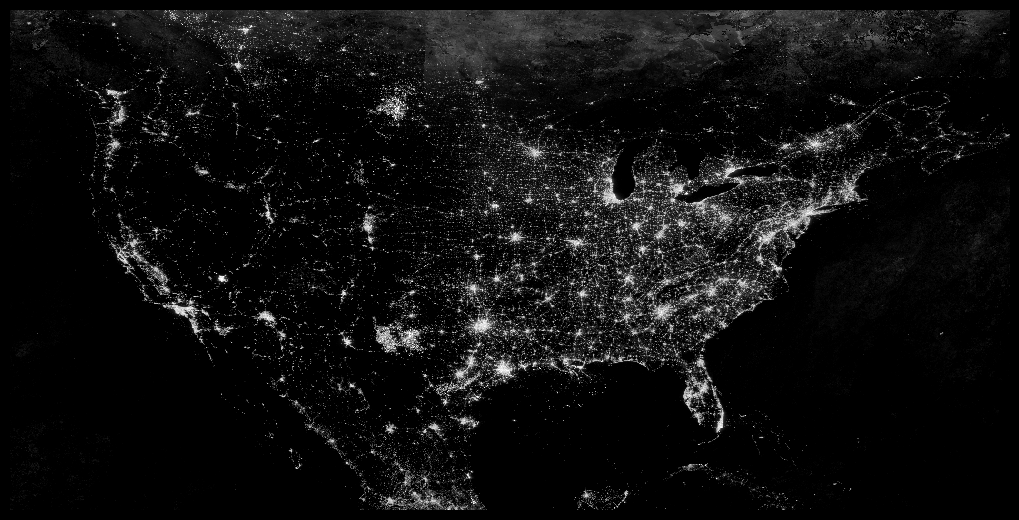

In [8]:
# -------------------------------------------------------------------
# 7. Plot
# -------------------------------------------------------------------
cmap = plt.get_cmap("gray").copy()
cmap.set_bad("black")
cmap.set_under("black")

fig, ax = plt.subplots(figsize=(10, 6), facecolor="black")
ax.set_facecolor("black")

img = ax.imshow(
    us_radiance,
    cmap=cmap,
    norm=LogNorm(vmin=low, vmax=high),
    extent=us_extent,
    origin="upper",
    interpolation="nearest" 
)
ax.axis("off")
plt.tight_layout(pad=0)
plt.margins(0, 0)

fig.savefig(
    "usa_nightlights.png",
    dpi=600,
    facecolor="black",
    bbox_inches="tight",
    pad_inches=0,
)

plt.show()